Imports:

In [ ]:
import tensorflow as tf
import os
import uuid                          # for generating unique filenames created during augmentation
import matplotlib.pyplot as plt

# for augmentation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# for deep-learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout

# for performance evaulation
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# for saving model
from tensorflow.keras.models import load_model

# for confusion matrix
import numpy as np

d:\APN\Classification Model\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
data_dir = r"D:\APN\Classification Model\data"         # good and bad images directory

displaying individual data (tensorflow)

In [3]:

# img_path = tf.strings.join([data_dir, "/good1/0.jpg"])          #joins the path, data_dir + /good1/0.jpg
# img = tf.io.read_file(img_path)                                 #Reads the image file from disk. Returns the raw file contents, not pixel values
# img = tf.image.decode_jpeg(img, channels=3)                     #Decodes a JPEG-encoded image to a uint8 tensor (raw file content to pixel values)
# # print(img)

# plt.imshow(img)                                                 # TensorFlow image tensors are already in RGB format, so no need to convert.
# plt.show()  

GPU VRAM max limit:

In [4]:
flag=False

if flag:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  #4 GB
        )

1. Visualization of batch of images 

 keras for loading directory, creating batch, image resize, for Visualization

In [ ]:
        # Loads images from a directory structure
        # Every image is automatically resized to 100×100 pixels.
        # Creates batches of 'x' images.
        # Returns a 'tf.data.Dataset' object, that ready for training / validation in TensorFlow/Keras models.
        # auto label images based on folder names ( here, bad = 0 and good = 1)
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=16,
    image_size=(100,100)
    )

Found 152 files belonging to 2 classes.


Augmentation

In [6]:

## augment each images with all augmentation types once 


flag=False

if flag:
    # Save augmented copies - one for each augmentation type
    # Note: This runs BEFORE normalization, so images are in [0, 255] range
    aug_save_dir = os.path.join(data_dir, "augmented")
    tf.io.gfile.makedirs(aug_save_dir)

    # Ensure class folders exist
    class_names = getattr(data, "class_names", ["bad1", "good1"])
    for cname in class_names:
        tf.io.gfile.makedirs(os.path.join(aug_save_dir, cname))

    saved = 0

    # Process each batch in the dataset
    for batch_images, batch_labels in data:
        # Process each image in the batch
        for img, label in zip(batch_images, batch_labels):
            label_int = int(label)
            img_normalized = img / 255.0
            
            # 1. Vertical flip (deterministic - always flips)
            flip_img = tf.image.flip_up_down(img_normalized)
            flip_img = tf.clip_by_value(flip_img, 0.0, 1.0)
            flip_uint8 = tf.cast(flip_img * 255.0, tf.uint8)
            filename = f"{class_names[label_int]}_flip_{uuid.uuid4().hex[:8]}.jpg"
            out_path = os.path.join(aug_save_dir, class_names[label_int], filename)
            tf.io.write_file(out_path, tf.io.encode_jpeg(flip_uint8))
            saved += 1
            
            # 2. Rotation (deterministic - always rotates)
            rotation_img = tf.image.rot90(img_normalized, k=1)  # 90 degrees rotation
            rotation_img = tf.clip_by_value(rotation_img, 0.0, 1.0)
            rotation_uint8 = tf.cast(rotation_img * 255.0, tf.uint8)
            filename = f"{class_names[label_int]}_rotation_{uuid.uuid4().hex[:8]}.jpg"
            out_path = os.path.join(aug_save_dir, class_names[label_int], filename)
            tf.io.write_file(out_path, tf.io.encode_jpeg(rotation_uint8))
            saved += 1
            
            # 3. Zoom (deterministic - always zooms by cropping center and resizing)
            h, w = img_normalized.shape[0], img_normalized.shape[1]
            crop_size = int(h * 0.7)  # 30% zoom
            start = (h - crop_size) // 2
            zoom_img = img_normalized[start:start+crop_size, start:start+crop_size, :]
            zoom_img = tf.image.resize(zoom_img, [h, w])
            zoom_img = tf.clip_by_value(zoom_img, 0.0, 1.0)
            zoom_uint8 = tf.cast(zoom_img * 255.0, tf.uint8)
            filename = f"{class_names[label_int]}_zoom_{uuid.uuid4().hex[:8]}.jpg"
            out_path = os.path.join(aug_save_dir, class_names[label_int], filename)
            tf.io.write_file(out_path, tf.io.encode_jpeg(zoom_uint8))
            saved += 1

    print(f"Augmented images saved: {saved}")
    print(f"Output dir: {aug_save_dir}")

2. Data scaling (( 0 to 255) -> (0 to 1)) Normalization

In [7]:
# x - images  (8,100,100,3) , y - labels  (8,)
data = data.map(lambda x,y: (x/255.0, y))    # Normalizes the images by scaling pixel values from [0, 255] to [0, 1]. Keeps labels unchanged.
scaled_iterator = data.as_numpy_iterator()     # Converts the normalized dataset to a NumPy iterator and retrieves the first batch.

Visualize the 16 batch images

Images shape: (16, 100, 100, 3)
Labels shape: (16,)
Max pixel value: 1.0
Min pixel value: 0.0


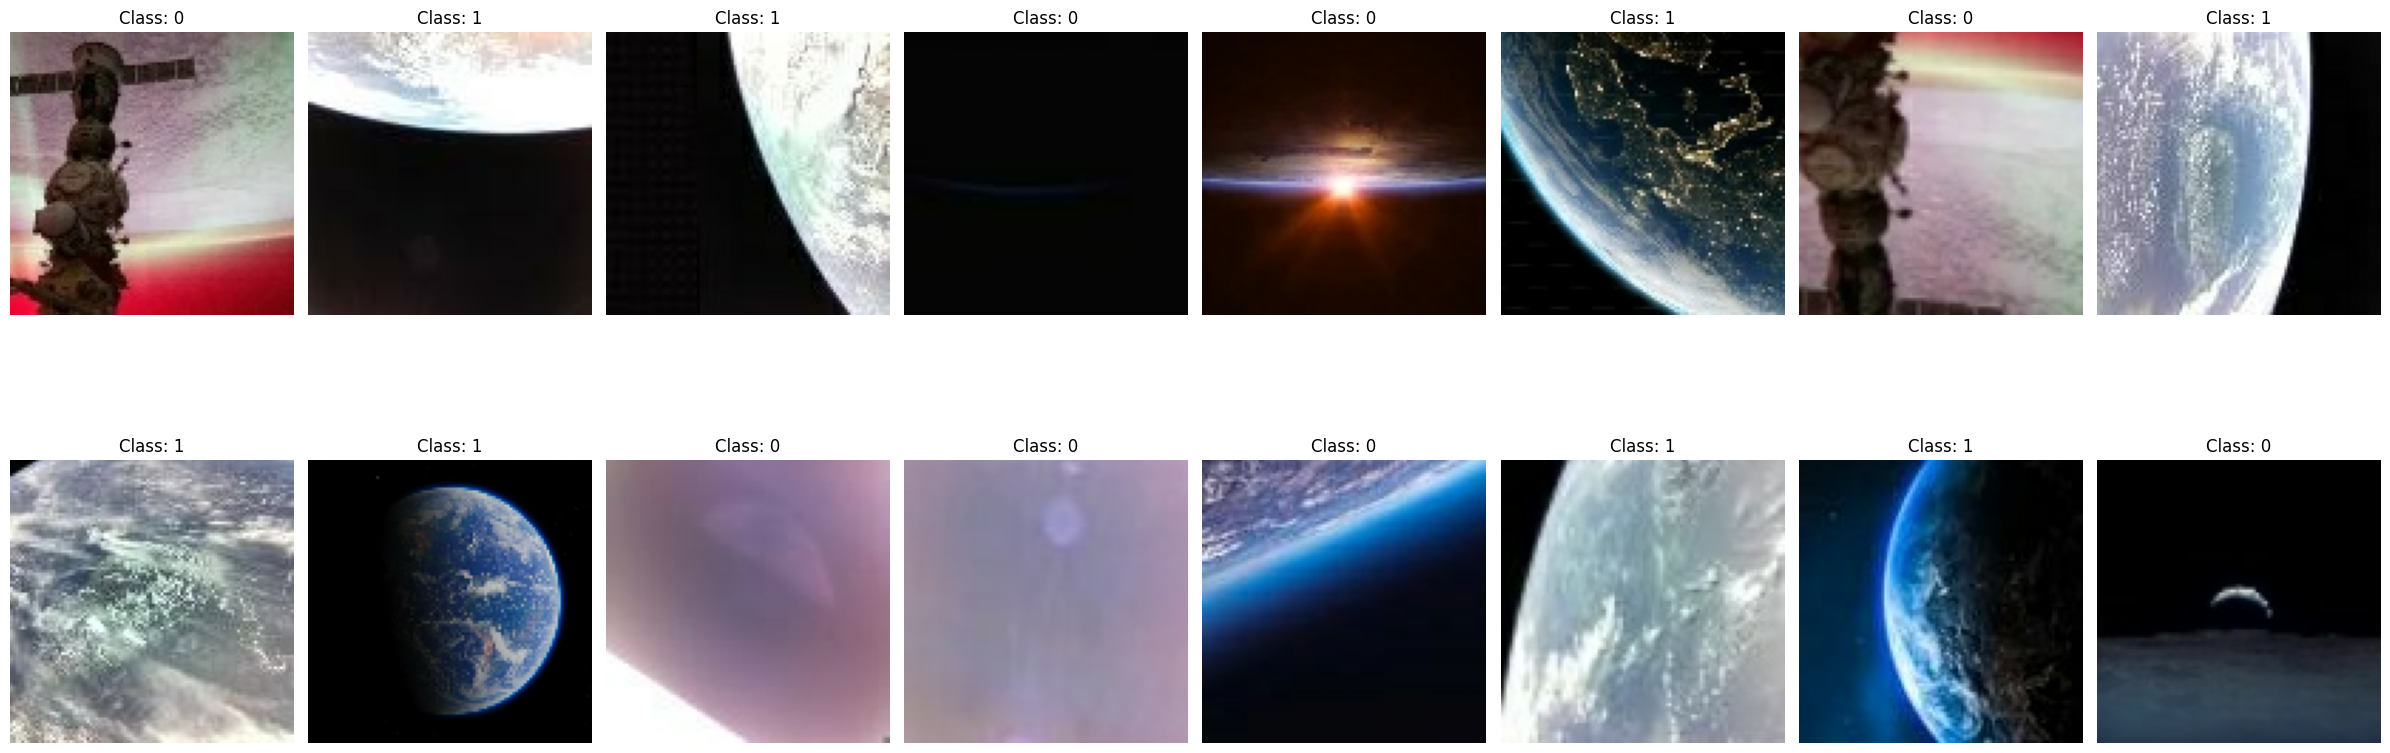

In [8]:
# Convert dataset to NumPy iterator, Libraries like Matplotlib expect NumPy arrays as input.
data_iterator = data.as_numpy_iterator()

# Get the first batch
batch = next(data_iterator)

# batch[0] = images, batch[1] = labels
print("Images shape:", batch[0].shape)          # (batch_size, height, width, channels)
print("Labels shape:", batch[1].shape)          # (batch_size,) which is tuple

print("Max pixel value:", batch[0].max())
print("Min pixel value:", batch[0].min())
# Number of images to display
num_images = 16
nrows = 2
ncols = 8

# Create grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 10))  # wider figsize for 8 cols

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through images and display
for idx in range(num_images):
    img = batch[0][idx] 
    label = batch[1][idx]

    axes[idx].imshow(img)
    axes[idx].set_title(f"Class: {label}")
    axes[idx].axis("off")

# Hide extra subplots (if any)
for idx in range(num_images, nrows*ncols):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()


Visualizing the scaled images.

In [9]:
flag = False

if flag:
    # Convert dataset to NumPy iterator
    scaled_iterator = data.as_numpy_iterator()

    # Get only the first batch
    batch = next(scaled_iterator)  # Get the first batch
    print(batch[1].shape)
    # Optionally, print min/max values for verification
    print("Max pixel value:", batch[0].max())
    print("Min pixel value:", batch[0].min())

    num_images = 16
    nrows = 2
    ncols = 8


    # Create the grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
    axes = axes.flatten()  # flatten to index easily

    # Plot each image
    for idx in range(num_images):
        img = batch[0][idx]
        label = batch[1][idx]
        axes[idx].imshow(img, vmin=0.0, vmax=1.0)
        axes[idx].set_title(f"Class: {label}")
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()



3. Splitting (can also be done on tf.keras.utils.image_dataset_from_directory( validation_split=0.2) ,... ,... )

In [10]:
print("Number of batches in the dataset:", len(data))  # Number of batches in the dataset

# train_size  ->  type: int  ->  Number of batches to take from the dataset (just a number)
train_size = int(len(data)*.7)                  # 70% of the data for training
val_size = int(len(data)*.2)                 # 20% of the data for validation 
test_size = int(len(data)*.1)              # 10% of the data for testing (for large datasets)

print("Number of Training batch:", train_size,
      "  |  ",
      "Number of Validation batch:", val_size, 
      "   |   "
    "Number of Testing batch:", test_size
      )

# train  ->  type: tf.data.Dataset  ->  The subset of the dataset that contains training batches
train = data.take(train_size)                               # Takes the first 'train_size' batches for training
val = data.skip(train_size).take(val_size)                  # Skips the training batches and takes the next 'val_size' batches for validation
test = data.skip(train_size+val_size).take(test_size)     # Skips the training and validation batches and takes the next 'test_size' batches for testing

print("Training batches:", len(train),
      "  |  ",
      "Validation batches:", len(val),
        "  |  ",
      "Testing batches:", len(test)
        )


Number of batches in the dataset: 10
Number of Training batch: 7   |   Number of Validation batch: 2    |   Number of Testing batch: 1
Training batches: 7   |   Validation batches: 2   |   Testing batches: 1


3. Deep Model

In [ ]:
# Model (data augmentation now applied to training data before this)
model = Sequential([
    #      filter  ,  kernel_size ,   stride     ,    padding      ,     activation      ,      input_shape
    Conv2D(  16    ,  (3,3) ,  2   , padding="same"  , activation='relu'  ,  input_shape=(100,100,3)),
    # BatchNormalization(),  # Added for consistency with other Conv2D layers
    # MaxPool2D(),
    Dropout(0.1),

    Conv2D(32, (3,3), 2 , padding="same", activation='relu'),
    # BatchNormalization(),
    # MaxPool2D(),
    Dropout(0.1),

    Conv2D(64, (3,3), 2 , padding="same", activation='relu'),
    # BatchNormalization(),
    MaxPool2D(),
    Dropout(0.1),

   
    # GlobalAveragePooling2D(),
    # Flatten(),
    # Dense(128, activation='relu'),   # Fully connected layer, it learns complex features but creating more combination of possibilities ,with less overfitting

    ## Flatten alternative
    Flatten(),
    Dense(256, activation='relu'),   # Fully connected layer, it learns complex features but creating more combination of possibilities ,with less overfitting
    Dropout(0.3),
    
    Dense(1, activation='sigmoid'),  # Binary classification output
])

d:\APN\Classification Model\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimizer and Learning Rate

In [333]:
# model.compile() tells the model:
#       How to update its weights → optimizer
#       How to measure errors → loss function
#       What metrics to track → metrics

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),       # how the model adjusts weights during training
                                                                    # Adam : popular optimizer that combines: Momentum(remembers past gradients) and Adaptive Learning rates (adjust step size per parameters)
                                                                    # Learning rate: 0.0005 ( smaller : slower but more accurate , larger : faster but less accurate )
    
    loss='binary_crossentropy',                 # Binary crossentropy = standard for binary classification (2 classes)
                                                # Measures the difference between: Predicted probability (sigmoid output) and Actual label (0 or 1)
    
    metrics=['accuracy']           # Metrics = what you track while training
                                   # Accuracy = proportion of correct predictions
                                   # Only for monitoring; not used to update weights
)


model.summary()

In [334]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,921 (2.34 MB)

 Trainable params: 613,921 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

3. Training data

In [335]:
logdir = 'logs'     # Directory to store TensorBoard logs , src/logs

In [336]:
 

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',                             # track validation loss
    patience=5,                                     # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True                       # restore model weights from the epoch with the best value of the monitored quantity
    )


hist = model.fit(
    train,                                          # training data  
    validation_data=val,                            # validation data
    epochs=25,                                      # number of complete passes through the training dataset
    callbacks=[early_stop]                          # early stopping to prevent overfitting
)



Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5446 - loss: 0.6935 - val_accuracy: 0.5312 - val_loss: 0.6821
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6071 - loss: 0.6765 - val_accuracy: 0.6562 - val_loss: 0.6642
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6250 - loss: 0.6725 - val_accuracy: 0.5312 - val_loss: 0.6608
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6250 - loss: 0.6512 - val_accuracy: 0.6250 - val_loss: 0.6748
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6518 - loss: 0.6642 - val_accuracy: 0.6562 - val_loss: 0.6471
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6875 - loss: 0.6455 - val_accuracy: 0.6562 - val_loss: 0.6474
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6161 - loss: 0.6505 - val_accuracy: 0.6250 - val_loss: 0.6320
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7500 - loss: 0.6245 - val_accuracy: 0.8125 - val_loss: 0.5745


Plot performance in graph


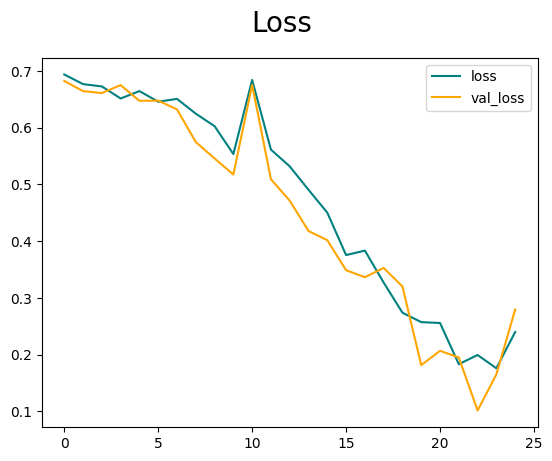

In [352]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')            
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')  
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()


Visualize Accuracy

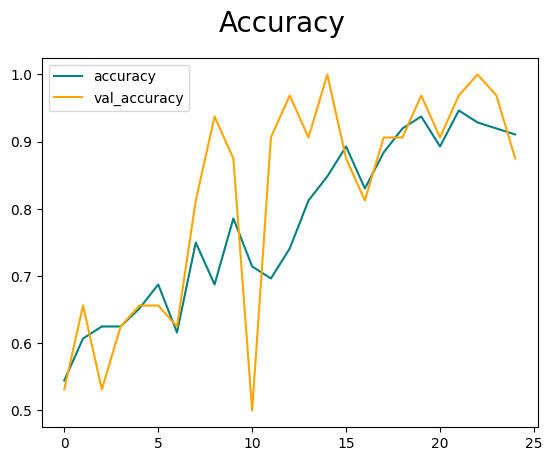

In [353]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')            
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

4. Evaluating Performance

In [355]:
pre = Precision()               # Initializes precision metric
re = Recall()                   # Initializes recall metric
acc = BinaryAccuracy()          # Initializes binary accuracy metric

In [356]:
len(test)

1

In [357]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    # y_pred_labels = tf.cast(y_pred > 0.5, tf.int32)  # Convert probabilities to binary labels (0 or 1)

    pre.update_state(y, y_pred)   # Update precision metric state
    re.update_state(y, y_pred)    # Update recall metric state
    acc.update_state(y, y_pred)   # Update accuracy metric state
    
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

# pre.result() → computes precision based on all updates so far,    # TP/(TP+FP)  , TP: True Positive, FP:False Positive, FN: False Negative, TN: True Negative
# re.result() → computes recall based on all updates so far,        # TP/(TP+FN)
# acc.result() → computes accuracy based on all updates so far      # (TP+TN)/(TP+TN+FP+FN)
# .numpy() → converts the TensorFlow tensor into a normal Python number

# higher value is better

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Precision: 1.0, Recall: 1.0, Accuracy: 1.0


Confusion Matrix

training set confusion matrix ( see how well model memorized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


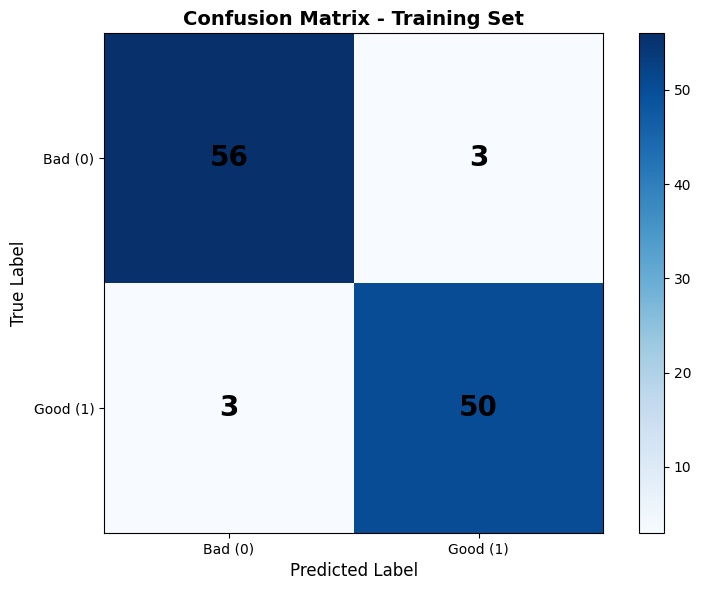


=== TRAINING SET Confusion Matrix ===
True Negatives (TN): 56 - Correctly predicted as Bad
False Positives (FP): 3 - Incorrectly predicted as Good (actually Bad)
False Negatives (FN): 3 - Incorrectly predicted as Bad (actually Good)
True Positives (TP): 50 - Correctly predicted as Good

Total predictions: 112
Accuracy: 94.64%


In [ ]:


# Collect all predictions and true labels from TRAINING set
y_true_all = []
y_pred_all = []

for batch in train.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred_labels = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary labels
    
    y_true_all.extend(y)
    y_pred_all.extend(y_pred_labels)

# Convert to numpy arrays
y_true_all = np.array(y_true_all, dtype=int)
y_pred_all = np.array(y_pred_all, dtype=int)

# Calculate confusion matrix manually
tn = np.sum((y_true_all == 0) & (y_pred_all == 0))  # True Negatives
fp = np.sum((y_true_all == 0) & (y_pred_all == 1))  # False Positives
fn = np.sum((y_true_all == 1) & (y_pred_all == 0))  # False Negatives
tp = np.sum((y_true_all == 1) & (y_pred_all == 1))  # True Positives

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
plt.colorbar(im, ax=ax)

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Bad (0)', 'Good (1)'])
ax.set_yticklabels(['Bad (0)', 'Good (1)'])

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", color="black", fontsize=20, fontweight='bold')

ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\n=== TRAINING SET Confusion Matrix ===")
print(f"True Negatives (TN): {tn} - Correctly predicted as Bad")
print(f"False Positives (FP): {fp} - Incorrectly predicted as Good (actually Bad)")
print(f"False Negatives (FN): {fn} - Incorrectly predicted as Bad (actually Good)")
print(f"True Positives (TP): {tp} - Correctly predicted as Good")
print(f"\nTotal predictions: {tn + fp + fn + tp}")
print(f"Accuracy: {(tn + tp) / (tn + fp + fn + tp) * 100:.2f}%")

validation set confusion matrix (tune model and detect overfitting)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


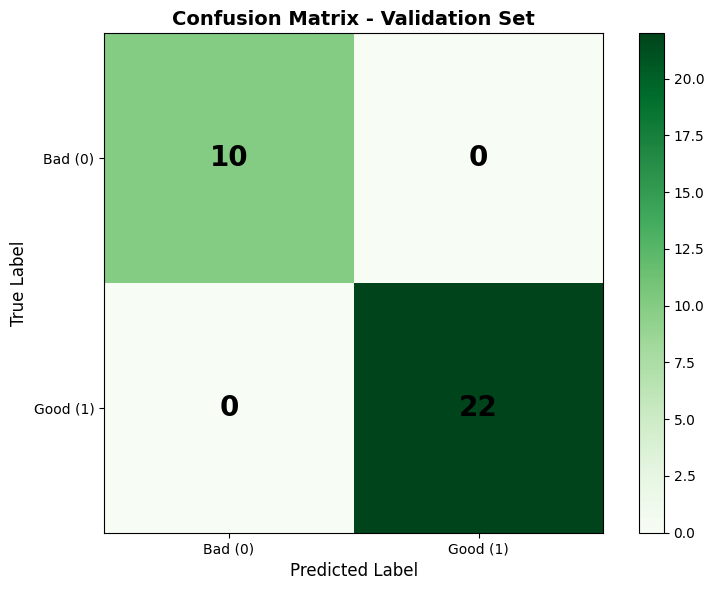


=== VALIDATION SET Confusion Matrix ===
True Negatives (TN): 10 - Correctly predicted as Bad
False Positives (FP): 0 - Incorrectly predicted as Good (actually Bad)
False Negatives (FN): 0 - Incorrectly predicted as Bad (actually Good)
True Positives (TP): 22 - Correctly predicted as Good

Total predictions: 32
Accuracy: 100.00%


In [ ]:

# Collect all predictions and true labels from VALIDATION set
y_true_all = []
y_pred_all = []

for batch in val.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred_labels = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary labels
    
    y_true_all.extend(y)
    y_pred_all.extend(y_pred_labels)

# Convert to numpy arrays
y_true_all = np.array(y_true_all, dtype=int)
y_pred_all = np.array(y_pred_all, dtype=int)

# Calculate confusion matrix manually
tn = np.sum((y_true_all == 0) & (y_pred_all == 0))  # True Negatives
fp = np.sum((y_true_all == 0) & (y_pred_all == 1))  # False Positives
fn = np.sum((y_true_all == 1) & (y_pred_all == 0))  # False Negatives
tp = np.sum((y_true_all == 1) & (y_pred_all == 1))  # True Positives

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Greens')

# Add colorbar
plt.colorbar(im, ax=ax)

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Bad (0)', 'Good (1)'])
ax.set_yticklabels(['Bad (0)', 'Good (1)'])

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", color="black", fontsize=20, fontweight='bold')

ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\n=== VALIDATION SET Confusion Matrix ===")
print(f"True Negatives (TN): {tn} - Correctly predicted as Bad")
print(f"False Positives (FP): {fp} - Incorrectly predicted as Good (actually Bad)")
print(f"False Negatives (FN): {fn} - Incorrectly predicted as Bad (actually Good)")
print(f"True Positives (TP): {tp} - Correctly predicted as Good")
print(f"\nTotal predictions: {tn + fp + fn + tp}")
print(f"Accuracy: {(tn + tp) / (tn + fp + fn + tp) * 100:.2f}%")

test set confusion matrix (final real-world performance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


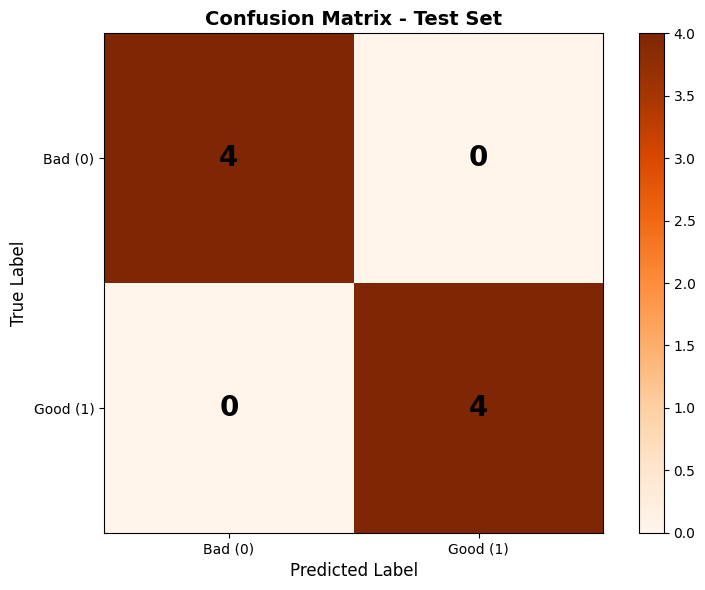


=== TEST SET Confusion Matrix ===
True Negatives (TN): 4 - Correctly predicted as Bad
False Positives (FP): 0 - Incorrectly predicted as Good (actually Bad)
False Negatives (FN): 0 - Incorrectly predicted as Bad (actually Good)
True Positives (TP): 4 - Correctly predicted as Good

Total predictions: 8
Accuracy: 100.00%


In [ ]:

# Collect all predictions and true labels from TEST set
y_true_all = []
y_pred_all = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred_labels = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary labels
    
    y_true_all.extend(y)
    y_pred_all.extend(y_pred_labels)

# Convert to numpy arrays
y_true_all = np.array(y_true_all, dtype=int)
y_pred_all = np.array(y_pred_all, dtype=int)

# Calculate confusion matrix manually
tn = np.sum((y_true_all == 0) & (y_pred_all == 0))  # True Negatives
fp = np.sum((y_true_all == 0) & (y_pred_all == 1))  # False Positives
fn = np.sum((y_true_all == 1) & (y_pred_all == 0))  # False Negatives
tp = np.sum((y_true_all == 1) & (y_pred_all == 1))  # True Positives

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Oranges')

# Add colorbar
plt.colorbar(im, ax=ax)

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Bad (0)', 'Good (1)'])
ax.set_yticklabels(['Bad (0)', 'Good (1)'])

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", color="black", fontsize=20, fontweight='bold')

ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\n=== TEST SET Confusion Matrix ===")
print(f"True Negatives (TN): {tn} - Correctly predicted as Bad")
print(f"False Positives (FP): {fp} - Incorrectly predicted as Good (actually Bad)")
print(f"False Negatives (FN): {fn} - Incorrectly predicted as Bad (actually Good)")
print(f"True Positives (TP): {tp} - Correctly predicted as Good")
print(f"\nTotal predictions: {tn + fp + fn + tp}")
print(f"Accuracy: {(tn + tp) / (tn + fp + fn + tp) * 100:.2f}%")

Inference

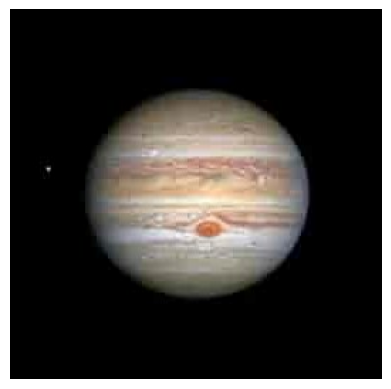

In [361]:

# img_path = '../test/Earth_from_Space.jpg'           # Path to image
# img_path = '../test/1.jpg' 
# img_path = '../test/earth3.jpg' 
img_path = '../test/hubbleviewjupiter.jpg'
# img_path = '../test/sunrise-in-space.jpg'
img = tf.io.read_file(img_path)                     # Load image as bytes
img = tf.image.decode_image(img, channels=3)        # Decode image (works for jpg, png, etc.)

# Display the original image
plt.imshow(img.numpy())
plt.axis('off')
plt.show()

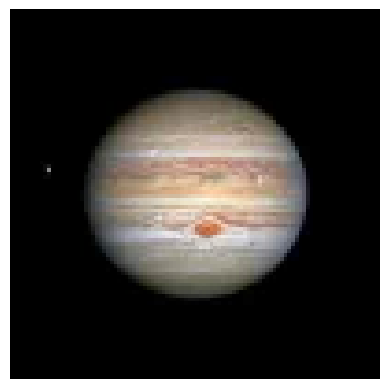

Resized shape: (100, 100, 3)


In [362]:
resize = tf.image.resize(img, (100, 100))  # Resize to 100x100
plt.imshow(resize.numpy().astype(int))
plt.axis('off')
plt.show()

print("Resized shape:", resize.shape)  # (100, 100, 3)


In [363]:
input_tensor = tf.expand_dims(resize, 0)  # Shape: (1, 100, 100, 3)
print("Input shape for model:", input_tensor.shape)


Input shape for model: (1, 100, 100, 3)


Normalize Pixel (scaling input image)

In [364]:
input_tensor = input_tensor / 255.0       #input image scaled to [0, 1] range

Predict the model.

In [365]:
yhat = model.predict(input_tensor)                          # Predicts the class probability for the input image
                                                            # Takes input tensor
                                                            # Passes it through all layers (Conv2D → GAP → Dense → Sigmoid)
                                                            # Returns the output of the final layer

# You can use yhat, but it’s still a NumPy array: To get a single number, you need [0][0] or .item()
yhat_value = yhat[0][0]
print("Predicted probability:", yhat[0][0])

# # Optional: convert probability to class label
# predicted_class = 1 if yhat[0][0] > 0.5 else 0
# print("Predicted class:", predicted_class)

if(yhat_value > 0.5):
    print("The image is classified as: Good")
else:
    print("The image is classified as: Bad")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted probability: 0.045111194
The image is classified as: Bad


5. Save the model

In [ ]:
flag=False


if flag:
    model.save('../models/FL_withdropout_16batch.keras')
    # Saves the trained model to the specified path in HDF5 format